In [ ]:
!pip3 install git+https://github.com/holounic/Bayesian-Optimization.git
!pip3 install cma

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/holounic/Bayesian-Optimization.git to /tmp/pip-req-build-jp3rd2_5
  Running command git clone -q https://github.com/holounic/Bayesian-Optimization.git /tmp/pip-req-build-jp3rd2_5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Cloning https://github.com/holounic/pyDOE to /tmp/pip-install-8574t8ez/pydoe_de9e9ce49c4045dba1a302656d44853c
  Running command git clone -q https://github.com/holounic/pyDOE /tmp/pip-install-8574t8ez/pydoe_de9e9ce49c4045dba1a302656d44853c
     |████████████████████████████████| 62 kB 1.0 MB/s 
     |████████████████████████████████| 316 kB 10.9 MB/s 
  Created wheel for bayes-optim: filename=bayes_optim-0.2.7-py3-none-any.whl size=145056 sha256=25a0e5dfbfe44942fd8a5434bbc33b928c400a655b9b0a999c9bdd05554ccb73
  Stored in directory: /tmp/pip-ephem-wheel-cache-

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import cma

from bayes_optim import BO
from bayes_optim.search_space import RealSpace
from bayes_optim.surrogate import GaussianProcess, trend

from pyDOE import lhs

from scipy.stats.qmc import Sobol, Halton

from benchmark.bbobbenchmarks import F21

from tqdm.notebook import tqdm, trange

import pandas as pd

np.random.seed(1111)

dim = 2
lb, ub = -5, 5

mean = trend.constant_trend(dim, beta=None)
thetaL = 1e-10 * (ub - lb) * np.ones(dim)
thetaU = 10 * (ub - lb) * np.ones(dim)
theta0 = np.random.rand(dim) * (thetaU - thetaL) + thetaL

max_FEs = 2**5
verbose = False

space = RealSpace([lb, ub], random_state=np.random.randint(1, 10000)) * dim
n_samples = 30000
samples = space.sample(n_samples)

doe_budget = 0.2
doe_size = int(doe_budget * max_FEs)

n_runs = 50
random_state = 1

In [ ]:
opt_color, found_color, initial_color = "green", "red", "blue"

def plot(points, colors, ax=plt, outline=False, marker='o', marker_size=30):
    transposed = np.transpose(points)
    if outline:
        ax.scatter(transposed[0], transposed[1], color="none", edgecolor=colors, marker=marker, s=marker_size)
    else:
        ax.scatter(transposed[0], transposed[1], c=colors, marker=marker, s=marker_size)


# plot DoE, optimum, found by the BO, and global optimum on the surface of the function
def plot_result(func, samples, values, result, ax):
  plot(samples, values, ax=ax, outline=False)
  if result["doe"] is not None:
    plot(result["doe"], ["blue"] * result["doe"].shape[0], ax=ax, marker='^')
  ax.set_title(f'{result.get("description", "regret")}: {result["regret"]}', size=6)
  plot([func._getxopt(), result["xopt"]], [opt_color, found_color], ax=ax, marker='s')


# plot DoE, all points used by the BO during training, global optimum, found optimum
def plot_ei_performance(func, samples, values, bo, result, marker_size=30, ax=None):
  if ax is None:
    ax = plt.gca()
  plot(samples, values, ax=ax, outline=False) # plot surface
  if result["doe"] is not None:
    plot(result["doe"], ["blue"] * result["doe"].shape[0], ax=ax, marker='^', marker_size=marker_size*2)
  
  for i in range(1, len(bo.history)):
    for h in bo.history[i]:
      x, y = h
      ax.scatter(x, y, color="magenta", s=marker_size)
      ax.annotate(str(i), h)
  plot([func._getxopt(), result["xopt"]], [opt_color, found_color], ax=ax, marker='s', marker_size=marker_size)

def plot_mult_performance(samples, results, marker_size=30):
    _, axs = plt.subplots(2, 2)
    for (ax, result) in zip(axs.flatten(), results):
      ax.title.set_text(result['title'])
      func = F21(result['f_s'])
      values = func(samples)
      plot_ei_performance(func, samples, values, result['bo'], result, marker_size=marker_size, ax=ax)

In [ ]:
def make_optimizer(obj_func, doe):
    model = GaussianProcess(
        mean=mean,
        corr="squared_exponential",
        theta0=theta0,
        thetaL=thetaL,
        thetaU=thetaU,
        nugget=0,
        noise_estim=False,
        optimizer="BFGS",
        wait_iter=3,
        random_start=dim,
        likelihood="concentrated",
        eval_budget=100 * dim
    )
    return BO(
        search_space=space,
        obj_fun=obj_func,
        model=model,
        DoE_size=len(doe),
        acquisition_fun="EI",
        initial_points=doe,
        max_FEs=max_FEs,
        verbose=verbose,
        n_point=1
    )

def compute_all(func_seed, doe, n=3, n_points=1000):
  regrets = []
  history = []
  precisions = []
  for seed in range(n):
    obj_func = F21(func_seed)
    bo = make_optimizer(obj_func, doe)
    xopt, yopt, _ = bo.run()
    regret = yopt - obj_func.getfopt()
    points = lhs(dim, n_points) * 10 - 5
    predicted_y = np.concatenate(bo.model.predict(points))
    real_y = obj_func(points)
    precision = np.mean((predicted_y - real_y)**2)
    precisions.append(precision)
    regrets.append(regret)
    history.append({'xopt': xopt, 'yopt': yopt, 'regret': regret, 'doe': doe, 'precision': precision, 'bo': bo, 'f_s': func_seed})
  return np.concatenate(regrets).mean(), np.mean(precisions), history

def compute_all_for(f, n=10):
  precisions, regrets, history = [], [], []
  for seed in trange(n):
    doe = f()
    r, p, h = compute_all(seed, doe, n=1, n_points=1000)
    precisions.append(p)
    regrets.append(r)
    history.append(h[0])
  return precisions, regrets, history

In [ ]:
def best_and_worst(history):
  def upd_min(t, c, f):
    if t is None:
      return c
    if t[f] > c[f]:
      return c
    return t
  def upd_max(t, c, f):
    if t is None:
      return c
    if t[f] < c[f]:
      return c
    return t
  best_regret, worst_regret = None, None
  best_precision, worst_precision = None, None
  for h in history:
    best_regret = upd_min(best_regret, h, 'regret')
    worst_regret = upd_max(worst_regret, h, 'regret')
    best_precision = upd_min(best_precision, h, 'precision')
    worst_precision = upd_max(worst_precision, h, 'precision')
  best_regret['title'] = 'min regret'
  worst_regret['title'] = 'max regret'
  best_precision['title'] = 'min precision'
  worst_precision['title'] = 'max precision'
  return best_regret, worst_regret, best_precision, worst_precision

In [ ]:
def additional_metrics(history):
  for h in history:
    f = F21(h['f_s'])
    y = f(h['xopt'])
    real_x = f._getxopt()
    d = np.linalg.norm(h['doe'] - real_x, axis=1)
    h['min_dist_to_opt'] = d.min()
    h['maxx_dist_to_opt'] = d.max()
    h['real_xopt'] = real_x
    h['real_yopt'] = f.getfopt()
    h['bo_history'] = h['bo'].history
  return history

def not_obvious(thr_d, thr_r):
  def func(h):
    f = F21(h['f_s'])
    y = f(h['xopt'])
    real_x = f._getxopt()
    return np.linalg.norm(h['doe'] - real_x, axis=1).min() > thr_d and h['regret'] < thr_r
  return func

def collect_by_criterion(history, criterion):
  good = []
  for h in history:
    if not criterion(h):
      continue
    good.append(h)
  return good

# Latin hypercube sampling


In [ ]:
def generate_lhs():
  return lhs(2, doe_size) * 10 - 5

In [ ]:
lhs_precision, lhs_regret, lhs_history = compute_all_for(generate_lhs, n=n_runs)
print(f'LHS precision: {np.mean(lhs_precision)}, Uniform regret: {np.mean(lhs_regret)}')

  0%|          | 0/50 [00:00<?, ?it/s]

LHS precision: 146725.4935178986, Uniform regret: 0.9845647487118502


LHS precision: min=115.5123024809158 max=1031985.1796520156,  LHS regret: min=[3.71425373e-05], max=[2.70704825]


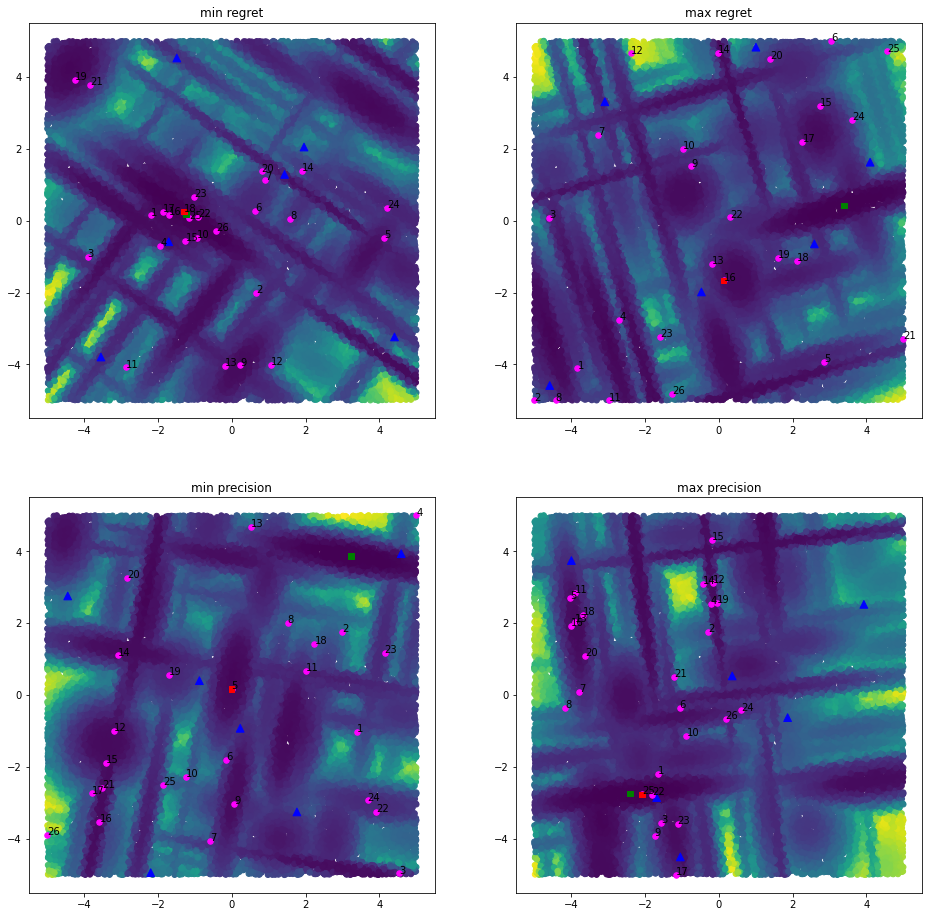

In [ ]:
plt.rcParams["figure.figsize"] = (16, 16)
lhs_best_regret, lhs_worst_regret, lhs_best_precision, lhs_worst_precision = best_and_worst(lhs_history)
print(f'LHS precision: min={lhs_best_precision["precision"]} max={lhs_worst_precision["precision"]},  LHS regret: min={lhs_best_regret["regret"]}, max={lhs_worst_regret["regret"]}')
plot_mult_performance(samples, (lhs_best_regret, lhs_worst_regret, lhs_best_precision, lhs_worst_precision), marker_size=30)

In [ ]:
lhs_df = pd.DataFrame(additional_metrics(lhs_history)).drop(['title', 'bo'], axis=1)
lhs_df.to_csv('lhs_doe21.csv')

In [ ]:
lhs_best_precision['precision'], lhs_best_precision['regret'], lhs_best_precision['f_s']

(115.5123024809158, array([1.26669337]), 31)

In [ ]:
lhs_best_regret['precision'], lhs_best_regret['regret'], lhs_best_precision['f_s']

(19722.585216514264, array([3.71425373e-05]), 31)

# Uniform

In [ ]:
def generate_uniform():
  return np.random.uniform(-5, 5, (doe_size, 2))

In [ ]:
uniform_precision, uniform_regret, uniform_history = compute_all_for(generate_uniform, n=n_runs)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
print(f'Uniform precision: {np.mean(uniform_precision)}, Uniform regret: {np.mean(uniform_regret)}')

Uniform precision: 146695.28566108402, Uniform regret: 0.9859879377730426


Uniform precision: min=128.69902498890846 max=1031971.5501450622,  Uniform regret: min=[0.0010509], max=[2.92770423]


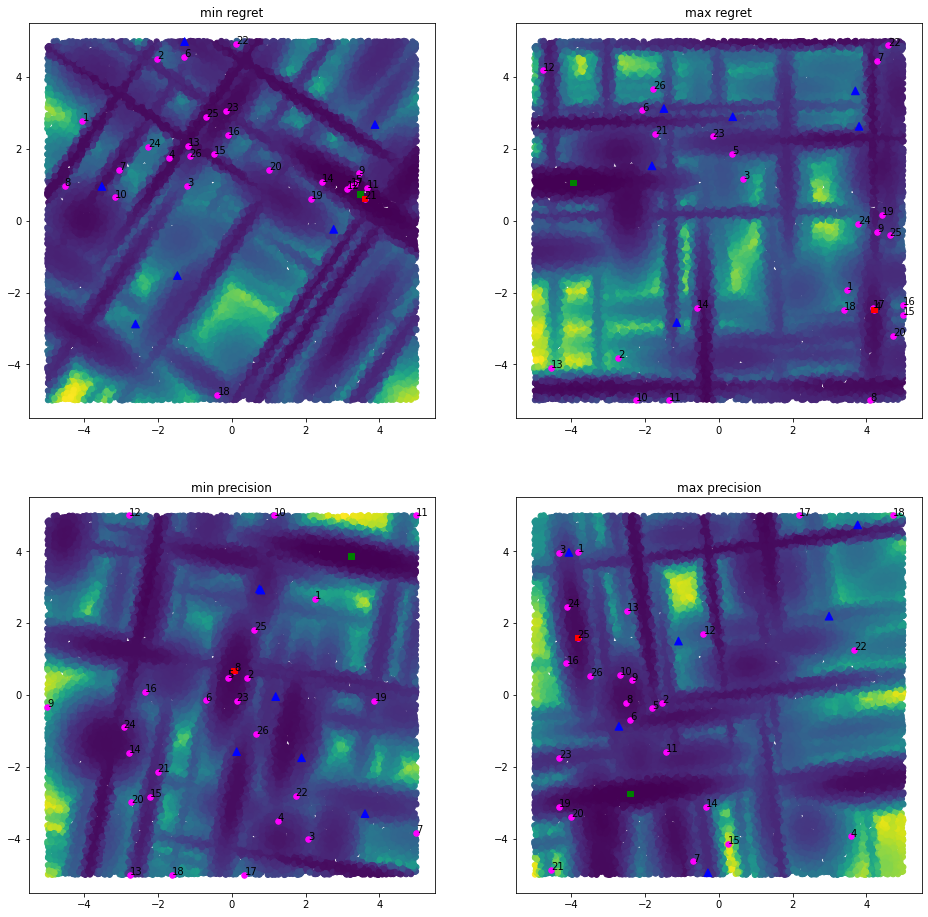

In [ ]:
plt.rcParams["figure.figsize"] = (16, 16)
uniform_best_regret, uniform_worst_regret, uniform_best_precision, uniform_worst_precision = best_and_worst(uniform_history)
print(f'Uniform precision: min={uniform_best_precision["precision"]} max={uniform_worst_precision["precision"]},  Uniform regret: min={uniform_best_regret["regret"]}, max={uniform_worst_regret["regret"]}')
plot_mult_performance(samples, (uniform_best_regret, uniform_worst_regret, uniform_best_precision, uniform_worst_precision), marker_size=30)

In [ ]:
uniform_df = pd.DataFrame(additional_metrics(uniform_history)).drop(['title', 'bo'], axis=1)
uniform_df.to_csv('uniform_doe21.csv')

In [ ]:
uniform_best_precision['precision'], uniform_best_precision['regret'], uniform_best_precision['f_s']

(128.69902498890846, array([1.02213383]), 31)

In [ ]:
uniform_best_regret['precision'], uniform_best_regret['regret'], uniform_best_regret['f_s']

(186.0601894304857, array([0.0010509]), 26)

# Sobol

In [ ]:
def generate_sobol():
  return Sobol(dim).random(doe_size) * 10 - 5

In [ ]:
sobol_precision, sobol_regret, sobol_history = compute_all_for(generate_sobol, n=n_runs)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
f'Sobol precision: {np.mean(sobol_precision)}, Sobol regret: {np.mean(sobol_regret)}'

'Sobol precision: 146809.0082241917, Sobol regret: 0.9303064464809278'

Sobol precision: min=108.54256078607384 max=1032705.9643608386,  Sobol regret: min=[1.9044858e-05], max=[4.2635545]


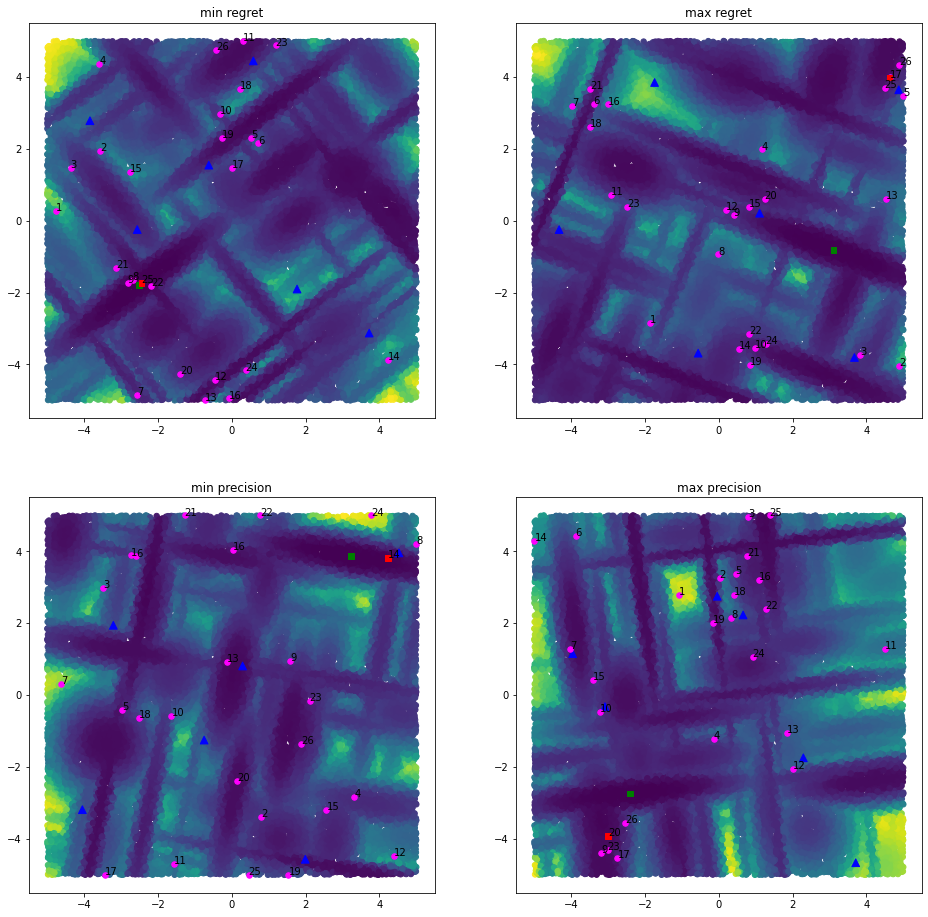

In [ ]:
plt.rcParams["figure.figsize"] = (16, 16)
sobol_best_regret, sobol_worst_regret, sobol_best_precision, sobol_worst_precision = best_and_worst(sobol_history)
print(f'Sobol precision: min={sobol_best_precision["precision"]} max={sobol_worst_precision["precision"]},  Sobol regret: min={sobol_best_regret["regret"]}, max={sobol_worst_regret["regret"]}')
plot_mult_performance(samples, (sobol_best_regret, sobol_worst_regret, sobol_best_precision, sobol_worst_precision), marker_size=30)

In [ ]:
sobol_df = pd.DataFrame(additional_metrics(sobol_history)).drop(['title', 'bo'], axis=1)
sobol_df.to_csv('sobol_doe21.csv')

In [ ]:
sobol_best_precision['precision'], sobol_best_precision['regret'], sobol_best_precision['f_s']

(108.54256078607384, array([0.47047444]), 31)

In [ ]:
sobol_best_regret['precision'], sobol_best_regret['regret'], sobol_best_regret['f_s']

(3068.3287552560196, array([1.9044858e-05]), 1)

# Halton

In [ ]:
def generate_halton():
  return Halton(dim).random(doe_size) * 10 - 5

In [ ]:
halton_precision, halton_regret, halton_history = compute_all_for(generate_halton, n=n_runs)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
f'Halton precision: {np.mean(halton_precision)}, Halton regret: {np.mean(halton_regret)}'

'Halton precision: 146709.23704709203, Halton regret: 0.9853912322683223'

Halton precision: min=117.96708306366462 max=1032531.8529114887,  Halton regret: min=[2.78139361e-05], max=[2.92580434]


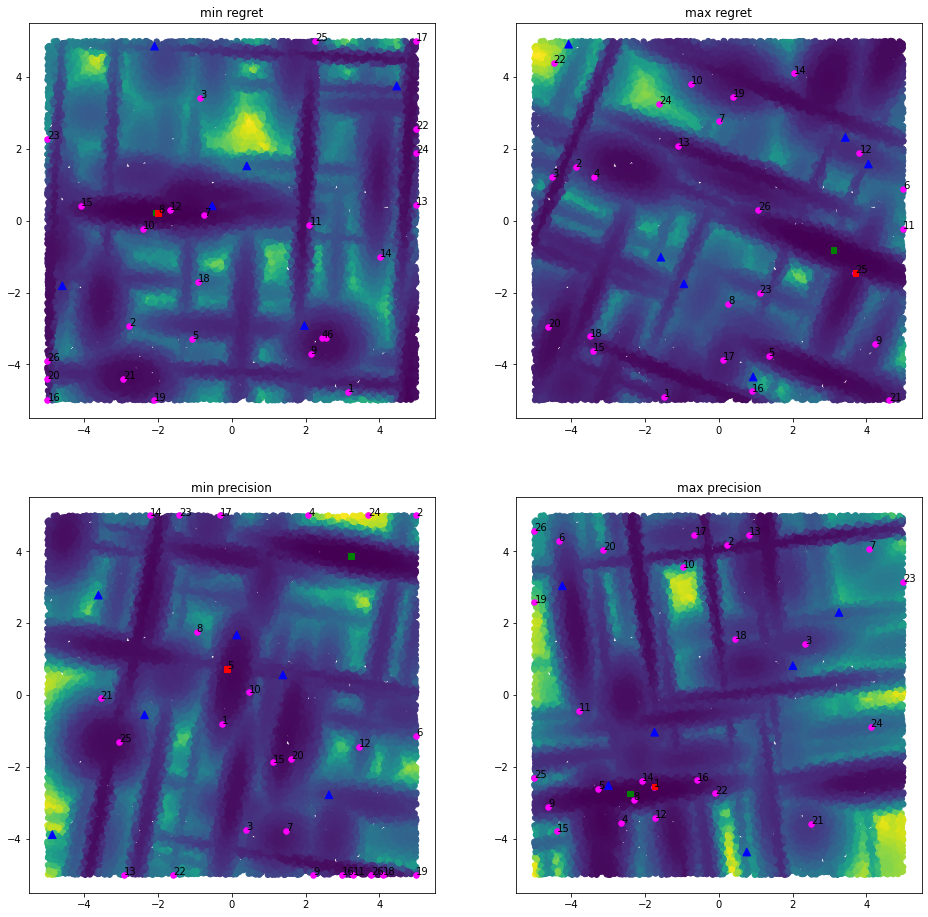

In [ ]:
plt.rcParams["figure.figsize"] = (16, 16)
halton_best_regret, halton_worst_regret, halton_best_precision, halton_worst_precision = best_and_worst(halton_history)
print(f'Halton precision: min={halton_best_precision["precision"]} max={halton_worst_precision["precision"]},  Halton regret: min={halton_best_regret["regret"]}, max={halton_worst_regret["regret"]}')
plot_mult_performance(samples, (halton_best_regret, halton_worst_regret, halton_best_precision, halton_worst_precision), marker_size=30)

In [ ]:
halton_df = pd.DataFrame(additional_metrics(halton_history)).drop(['title', 'bo'], axis=1)
halton_df.to_csv('halton_doe21.csv')

In [ ]:
halton_best_precision['precision'], halton_best_precision['regret'], halton_best_precision['f_s']

(117.96708306366462, array([1.92070806]), 31)

In [ ]:
halton_best_regret['precision'], halton_best_regret['regret'], halton_best_regret['f_s']

(6244.3608952415625, array([2.78139361e-05]), 34)

# Compare

In [ ]:
all_history = (lhs_history, uniform_history, sobol_history, halton_history)
all_titles = ("lhs", "uniform", "sobol", "halton")

## Regret boxplots

Text(0.5, 1.0, 'Regret')

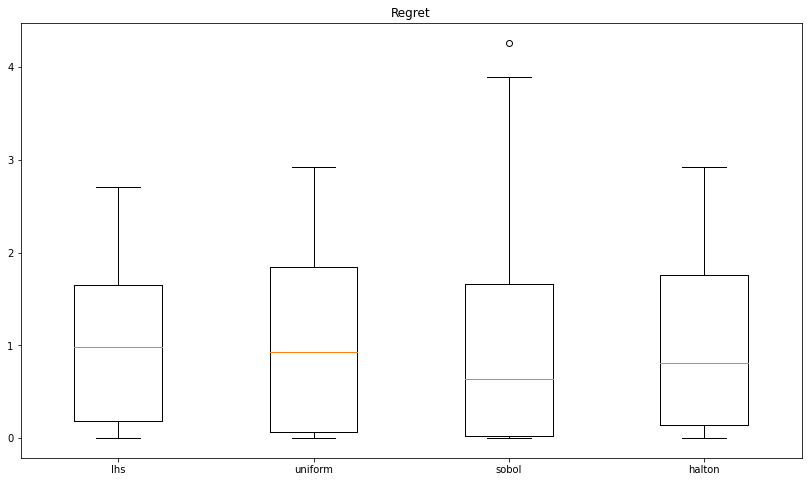

In [ ]:
plt.rcParams["figure.figsize"] = (14, 8)
rs = [np.concatenate([result['regret'] for result in history]) for history in all_history]
plt.boxplot(rs)
plt.xticks(list(range(1, len(all_history) + 1)), all_titles)
plt.title('Regret')

Text(0.5, 1.0, 'Log regret')

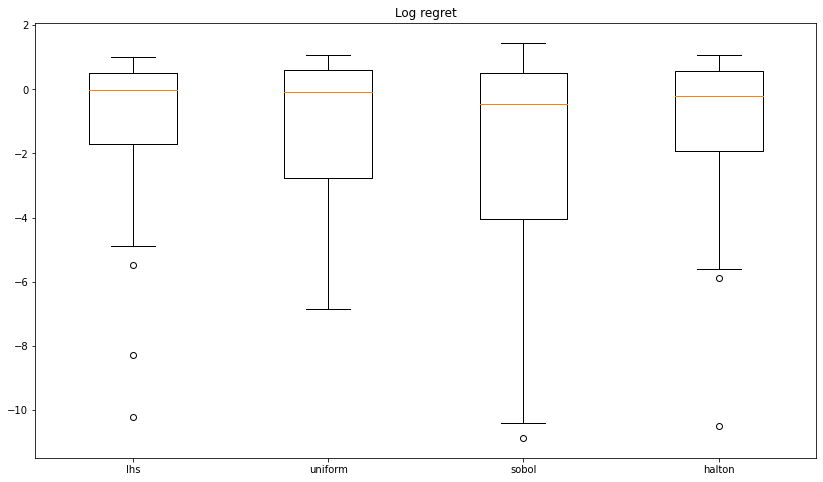

In [ ]:
plt.rcParams["figure.figsize"] = (14, 8)
rs = [np.concatenate([np.log(result['regret']) for result in history]) for history in all_history]
plt.boxplot(rs)
plt.xticks(list(range(1, len(all_history) + 1)), all_titles)
plt.title('Log regret')

## Precision boxplots

Text(0.5, 1.0, 'Precision')

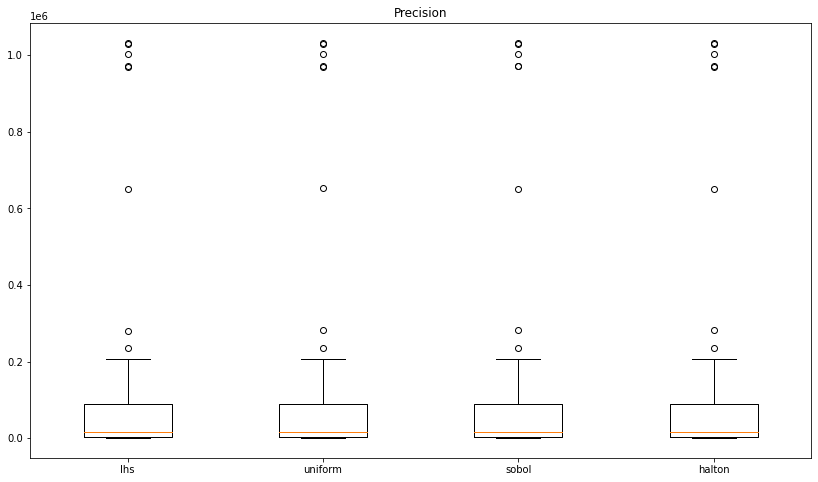

In [ ]:
plt.rcParams["figure.figsize"] = (14, 8)
rs = [[result['precision'] for result in history] for history in all_history]
plt.boxplot(rs)
plt.xticks(list(range(1, len(all_history) + 1)), ["lhs", "uniform", "sobol", "halton"])
plt.title('Precision')

Text(0.5, 1.0, 'Log precision')

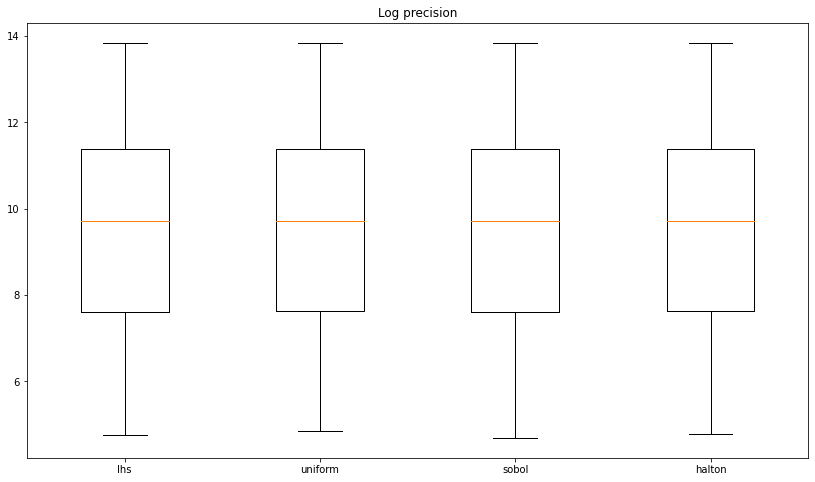

In [ ]:
plt.rcParams["figure.figsize"] = (14, 8)
rs = [[np.log(result['precision']) for result in history] for history in all_history]
plt.boxplot(rs)
plt.xticks(list(range(1, len(all_history) + 1)), ["lhs", "uniform", "sobol", "halton"])
plt.title('Log precision')

## Regret-precision dep

Text(0, 0.5, 'log regret')

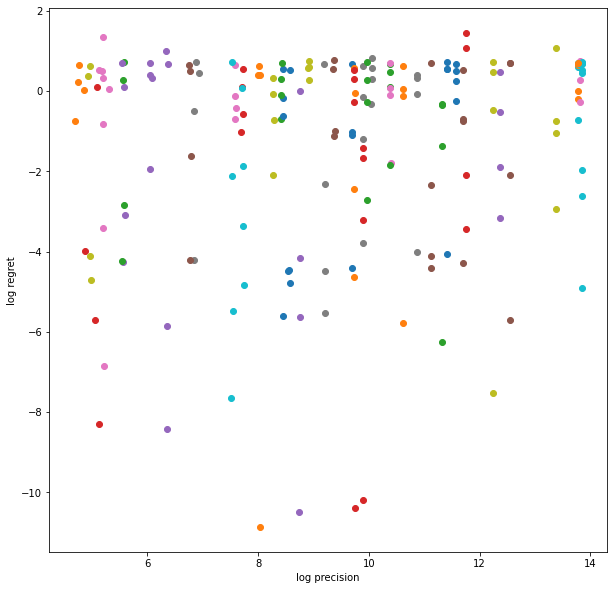

In [ ]:
plt.rcParams["figure.figsize"] = (10, 10)
for info in (lhs_history + uniform_history + sobol_history + halton_history):
  plt.scatter(np.log(info['precision']), np.log(info['regret']))
plt.xlabel('log precision')
plt.ylabel('log regret')